# 0.Prework

In [1]:
# 그래프에서 한글이 깨지지 않게 폰트 설치. 
# 맨처음 실행 후 런타임 다시시작해야 반영됨
# colab이라면 cell에서, Linux 등의 환경이라면 터미널 통해서 아래 코드 실행
'''
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
'''

'''
!pip install transformers
!pip install sentencepiece # MarianTokenizer 불러올 때 필요
!pip install sacremoses # MarianMTModel 에서 불러올 때 warning 뜨는 것 방지
'''

'\n!pip install transformers\n!pip install sentencepiece # MarianTokenizer 불러올 때 필요\n!pip install sacremoses # MarianMTModel 에서 불러올 때 warning 뜨는 것 방지\n'

# 1.Load Data & Preview

In [2]:
import pandas as pd
import torch

In [3]:
data = pd.read_excel('./대화체.xlsx')
data.head()

,대분류,소분류,상황,Set Nr.,발화자,원문,번역문
0,비즈니스,회의,의견 교환하기,1,A-1,이번 신제품 출시에 대한 시장의 반응은 어떤가요?,How is the market's reaction to the newly rele...
1,비즈니스,회의,의견 교환하기,1,B-1,판매량이 지난번 제품보다 빠르게 늘고 있습니다.,The sales increase is faster than the previous...
2,비즈니스,회의,의견 교환하기,1,A-2,그렇다면 공장에 연락해서 주문량을 더 늘려야겠네요.,"Then, we'll have to call the manufacturer and ..."
3,비즈니스,회의,의견 교환하기,1,B-2,"네, 제가 연락해서 주문량을 2배로 늘리겠습니다.","Sure, I'll make a call and double the volume o..."
4,비즈니스,회의,의견 교환하기,2,A-1,지난 회의 마지막에 논의했던 안건을 다시 볼까요?,Shall we take a look at the issues we discusse...


In [4]:
BATCH_SIZE = 128 ## 논문에선 2.5만 token이 한 batch에 담기게 했다고 함.
EPOCH = 30 ## 논문에선 약 560 에포크 진행
max_len = 512
d_model = 512

warmup_steps = int(95_104/BATCH_SIZE*EPOCH*0.04) ## 논문에선 4,000 스탭(전체의 4%)
LR_scale = 1 # Noam scheduler에 peak LR 값 조절을 위해 곱해질 녀석 

warmup_steps

891

In [5]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        return self.data.loc[idx, '원문'], self.data.loc[idx, '번역문']

data = pd.read_excel('대화체.xlsx')
custom_DS = CustomDataset(data)

train_DS, val_DS, test_DS = torch.utils.data.random_split(custom_DS, [95104, 3896, 1000])

train_DL = torch.utils.data.DataLoader(train_DS, batch_size=BATCH_SIZE, shuffle=True)
val_DL = torch.utils.data.DataLoader(val_DS, batch_size=BATCH_SIZE, shuffle=True)
test_DL = torch.utils.data.DataLoader(test_DS, batch_size=BATCH_SIZE, shuffle=True)

print(len(train_DS))
print(len(val_DS))
print(len(test_DS))

95104
3896
1000


# 1.Import Libraries

In [6]:
import time
import torch
from torch import nn, optim
import torch.nn.functional as F
from transformers import MarianMTModel, MarianTokenizer
import pandas as pd
from tqdm import tqdm
import math
import matplotlib.pyplot as plt

import plotly.graph_objs as go

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 2.Load Tokenizer

In [7]:
# Load tokenizer
tokenizer = MarianTokenizer.from_pretrained('Helsinki-NLP/opus-mt-ko-en')

eos_idx = tokenizer.eos_token_id
pad_idx = tokenizer.pad_token_id
print("eos_idx = ", eos_idx)
print("pad_idx = ", pad_idx)

eos_idx =  0
pad_idx =  65000


In [8]:
vocab_size = tokenizer.vocab_size
print(f'tokenizer의 사전 크기: {vocab_size}')

tokenizer의 사전 크기: 65001


In [9]:
text = 'Tokenizer Test is Started with Hugginface MarianTokenizer'
print(f"original : {text}")
print(f"token : {tokenizer.tokenize(text)}")

original : Tokenizer Test is Started with Hugginface MarianTokenizer
token : ['▁', 'To', 'k', 'en', 'iz', 'er', '▁T', 'est', '▁is', '▁St', 'art', 'ed', '▁with', '▁H', 'ug', 'g', 'in', 'f', 'ace', '▁Mar', 'ian', 'To', 'k', 'en', 'iz', 'er']


In [10]:
text = '허깅페이스 마리안 토크나이저로 수행하는 토크나이저 테스트'
print(f"original : {text}")
print(f"token : {tokenizer.tokenize(text)}")

original : 허깅페이스 마리안 토크나이저로 수행하는 토크나이저 테스트
token : ['▁허', '깅', '페이스', '▁마리', '안', '▁토', '크', '나이', '저', '로', '▁수', '행하는', '▁토', '크', '나이', '저', '▁테스트']


In [11]:
text = '문장을 넣으면 토크나이즈해서 숫자로 바꿔줍니다.'

tokenized = tokenizer.tokenize(text)
encoded_tokens = tokenizer.encode(text, add_special_tokens=False)
encoded_tokens_end = tokenizer.encode(text, add_special_tokens=True)

print(tokenized)
print(encoded_tokens)
print(encoded_tokens_end)

['▁문장', '을', '▁넣으면', '▁토', '크', '나이', '즈', '해서', '▁숫자', '로', '▁바꿔', '줍니다', '.']
[13774, 51, 40068, 4155, 1020, 5037, 1329, 969, 6635, 131, 8104, 6839, 2]
[13774, 51, 40068, 4155, 1020, 5037, 1329, 969, 6635, 131, 8104, 6839, 2, 0]


In [12]:
print(tokenizer.decode([0]))

</s>


In [13]:
print(tokenizer.decode([13774]))

▁문장


In [14]:
tokenizer.decode(encoded_tokens)

'▁문장을▁넣으면▁토크나이즈해서▁숫자로▁바꿔줍니다.'

# 3.Scheduler & Optimizer

## Noam Scheduler 공식

### $\text{Learning Rate} = \frac{1}{\sqrt{d_{\text{model}}}} \times \min\left(\frac{1}{\sqrt{\text{step\_num}}}, \frac{\text{step\_num}}{\text{warmup\_steps}^{1.5}}\right)$

In [15]:
def count_params(model):
    num = sum([p.numel() for p in model.parameters() if p.requires_grad])
    return num

class NoamScheduler:
    def __init__(self, optimizer, d_model, warmup_steps, LR_scale=1):
        self.optimizer = optimizer  # 최적화할 옵티마이저
        self.step_count = 0  # 현재까지 진행된 스텝 수
        self.d_model = d_model  # 모델의 차원 수
        self.warmup_steps = warmup_steps  # 웜업 단계에서의 스텝 수
        self.LR_scale = LR_scale  # 학습률 스케일 인자
        self._d_model_factor = self.LR_scale * (self.d_model ** -0.5)  # 모델 차원에 대한 계수를 미리 계산

    def step(self):
        self.step_count += 1  # 스텝 수 증가
        lr = self.calculate_learning_rate()  # 새 학습률 계산
        self.optimizer.param_groups[0]['lr'] = lr  # 옵티마이저의 학습률 갱신

    def calculate_learning_rate(self):
        # 초기 웜업 단계에서는 학습률을 서서히 증가시키고, 이후에는 감소시키는 방식으로 계산
        minimum_factor = min(self.step_count ** -0.5, self.step_count * self.warmup_steps ** -1.5)
        return self._d_model_factor * minimum_factor
        
def plot_scheduler(scheduler_name, optimizer, scheduler, total_steps): # LR curve 보기
    lr_history = []
    steps = range(1, total_steps)

    for _ in steps: # base model -> 10만 steps (12시간), big model -> 30만 steps (3.5일) 로 훈련했다고 함
        lr_history += [optimizer.param_groups[0]['lr']]
        scheduler.step()

    plt.figure()
    if total_steps == 100000:
        plt.plot(steps, (512 ** -0.5) * torch.tensor(steps) ** -0.5, 'g--', linewidth=1, label=r"$d_{\mathrm{model}}^{-0.5} \cdot \mathrm{step}^{-0.5}$")
        plt.plot(steps, (512 ** -0.5) * torch.tensor(steps) * 4000 ** -1.5, 'r--', linewidth=1, label=r"$d_{\mathrm{model}}^{-0.5} \cdot \mathrm{step} \cdot \mathrm{warmup\_steps}^{-1.5}$")    
    plt.plot(steps, lr_history, 'b', linewidth=2, alpha=0.35, label="Learning Rate")

    plt.ylim([-0.1*max(lr_history), 1.2*max(lr_history)])
    plt.xlabel('Step')
    plt.ylabel('Learning Rate')
    plt.grid()
    plt.legend()
    plt.show()

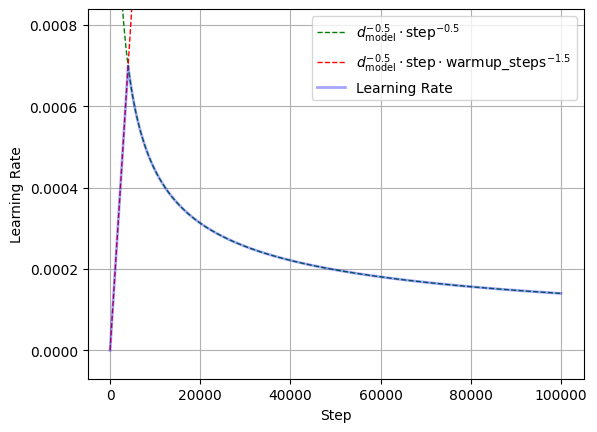

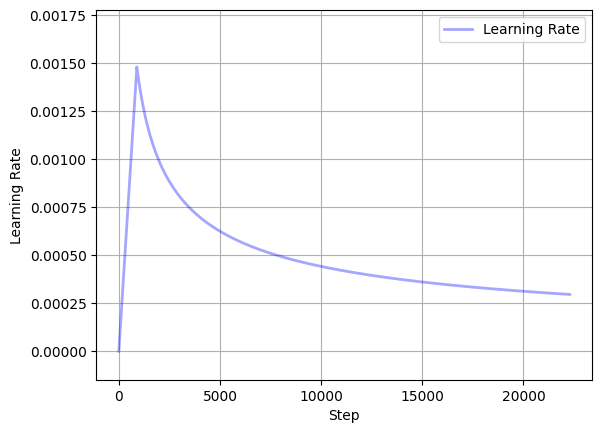

In [16]:
optimizer = optim.Adam(nn.Linear(1, 1).parameters(), lr=0) # 테스트용 optimizer
scheduler = NoamScheduler(optimizer, d_model=512, warmup_steps=4000) # 논문 값
plot_scheduler(scheduler_name = 'Noam', optimizer = optimizer, scheduler = scheduler, total_steps = 100000)

optimizer = optim.Adam(nn.Linear(1, 1).parameters(), lr=0)
scheduler = NoamScheduler(optimizer, d_model=d_model, warmup_steps=warmup_steps, LR_scale=LR_scale)
plot_scheduler(scheduler_name = 'Noam', optimizer = optimizer, scheduler = scheduler, total_steps = int(len(train_DS)*EPOCH/BATCH_SIZE))

# 4.Regularization - Label Smoothing Loss

In [17]:
def smooth_label(targets: torch.Tensor, classes: int, smoothing=0.1):
    assert 0 <= smoothing < 1
    confidence = 1.0 - smoothing
    label_shape = torch.Size((targets.size(0), classes))
    with torch.no_grad():
        smooth_labels = torch.empty(size=label_shape, device=targets.device)
        smooth_labels.fill_(smoothing / (classes - 1))
        smooth_labels.scatter_(1, targets.data.unsqueeze(1), confidence)
    return smooth_labels

def custom_cross_entropy(input, target, smoothing=0.1, ignore_index=-100):
    log_probs = F.log_softmax(input, dim=-1)
    target = smooth_label(target, input.size(-1), smoothing)
    
    if ignore_index >= 0:
        mask = target != ignore_index
        target = target[mask]
        log_probs = log_probs[mask]

    loss = (-target * log_probs).sum(dim=-1)
    return loss.mean()

In [18]:
input = torch.randn(3, 5, requires_grad=True) # 임의의 예측값
target = torch.tensor([1, 0, 4])  # 실제 레이블
label = smooth_label(target, input.size(-1), 0.0)
label_smoothing = smooth_label(target, input.size(-1), 0.1)

loss = custom_cross_entropy(input, target, smoothing=0.0, ignore_index=pad_idx)
loss_smoothing = custom_cross_entropy(input, target, smoothing=0.1, ignore_index=pad_idx)
input, label, label_smoothing, loss, loss_smoothing

(tensor([[-0.1993, -0.9216,  0.3962, -0.8220, -1.0800],
         [ 0.8364,  0.3906,  0.2776,  0.9380,  1.0257],
         [ 0.3393,  0.3242, -1.7673, -0.6988,  0.0442]], requires_grad=True),
 tensor([[0., 1., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1.]]),
 tensor([[0.0250, 0.9000, 0.0250, 0.0250, 0.0250],
         [0.9000, 0.0250, 0.0250, 0.0250, 0.0250],
         [0.0250, 0.0250, 0.0250, 0.0250, 0.9000]]),
 tensor(5.1394, grad_fn=<MeanBackward0>),
 tensor(5.1572, grad_fn=<MeanBackward0>))

In [19]:
class LabelSmoothingCrossEntropyLoss(nn.Module):
    def __init__(self, smoothing=0.1, ignore_index=65000):
        super(LabelSmoothingCrossEntropyLoss, self).__init__()
        # 스무딩 파라미터 설정. 0에 가까울수록 일반 크로스 엔트로피에 가까움
        self.smoothing = smoothing
        # 무시할 레이블(패딩)의 인덱스. 이 인덱스에 해당하는 레이블은 손실 계산에서 제외
        self.ignore_index = ignore_index

    def forward(self, input, target):
        # 입력 텍스트에 대한 로그 소프트맥스를 적용하여 모델의 예측 로그 확률을 계산
        log_probs = F.log_softmax(input, dim=-1)
        # 출력 언어의 어휘 크기를 계산 - 일반적인 분류 문제에서는 클래스의 수
        n_classes = input.size(-1)

        with torch.no_grad():
            # 스무딩된 레이블 분포를 생성. 각 클래스(어휘)에 작은 확률을 할당해 다양한 번역을 고려하도록 
            true_dist = torch.full_like(log_probs, self.smoothing / (n_classes - 1))
            # 무시할 레이블을 처리합니다. -> 패딩 토큰
            ignore = target == self.ignore_index
            # 무시할 레이블을 0으로 설정
            target = target.masked_fill(ignore, 0)
            # 실제 레이블 위치에 (1 - 스무딩) 값을 할당
            true_dist.scatter_(1, target.unsqueeze(1), 1.0 - self.smoothing)
            # 무시할 레이블의 위치에 0을 할당
            true_dist.masked_fill_(ignore.unsqueeze(1), 0)

            # 무시할 인덱스에 대한 마스크를 생성
            mask = ~ignore

        # 손실을 계산합니다. 마스크를 적용하여 무시할 인덱스를 제외
        loss = -true_dist * log_probs
        # 최종 손실을 평균내어 반환
        loss = loss.masked_select(mask.unsqueeze(1)).mean()

        return loss

In [20]:
# Case 1: Label Smoothing + CE Loss
criterion = LabelSmoothingCrossEntropyLoss(smoothing=0.1, ignore_index=pad_idx)
# Case 2: CE Loss only
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

In [21]:
# Case 1: Label Smoothing + CE Loss
criterion = nn.CrossEntropyLoss(label_smoothing=0.1, ignore_index=pad_idx)
# Case 2: CE Loss only
criterion = nn.CrossEntropyLoss(label_smoothing=0.0,ignore_index=pad_idx)

In [22]:
# paper
criterion = nn.CrossEntropyLoss(label_smoothing=0.1,ignore_index=pad_idx)

# 5.Modeling

## 1)MHA

In [23]:
class MHA(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()

        self.d_model = d_model
        self.n_heads = n_heads
        assert d_model % n_heads == 0, f'd_model ({d_model})은 n_heads ({n_heads})로 나누어 떨어져야 합니다.'

        self.head_dim = d_model // n_heads  # int 형변환 제거

        # 쿼리, 키, 값에 대한 선형 변환
        self.fc_q = nn.Linear(d_model, d_model) 
        self.fc_k = nn.Linear(d_model, d_model) 
        self.fc_v = nn.Linear(d_model, d_model)
        self.fc_o = nn.Linear(d_model, d_model)

        # 어텐션 점수를 위한 스케일 요소
        self.scale = torch.sqrt(torch.tensor(self.head_dim, dtype=torch.float32))

    def forward(self, Q, K, V, mask=None):
        batch_size = Q.shape[0]

        # 쿼리, 키, 값에 대한 선형 변환 수행
        Q = self.fc_q(Q) 
        K = self.fc_k(K)
        V = self.fc_v(V)

        # 멀티 헤드 어텐션을 위해 텐서 재구성 및 순서 변경
        Q = Q.reshape(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.reshape(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.reshape(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)

        # 스케일드 닷-프로덕트 어텐션 계산
        attention_score = Q @ K.permute(0, 1, 3, 2) / self.scale

        # 마스크 적용 (제공된 경우)
        if mask is not None:
            attention_score = attention_score.masked_fill(mask, -1e10)

        # 소프트맥스를 사용하여 어텐션 확률 계산
        attention_dist = torch.softmax(attention_score, dim=-1)

        # 어텐션 결과
        attention = attention_dist @ V

        # 어텐션 헤드 재조립
        x = attention.permute(0, 2, 1, 3).reshape(batch_size, -1, self.d_model)

        # 최종 선형 변환
        x = self.fc_o(x)

        return x, attention_dist

## 2)Feed Forward Network

In [24]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, drop_p):
        super().__init__()

        self.linear = nn.Sequential(nn.Linear(d_model, d_ff),
                                    nn.ReLU(),
                                    nn.Dropout(drop_p),       ## ADD Dropout
                                    nn.Linear(d_ff, d_model))
    
    def forward(self, x):
        x = self.linear(x)
        return x

## 3)Encoder Components

In [25]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, drop_p):
        """
        EncoderLayer 클래스의 초기화 메소드입니다.
        :param d_model: 모델의 차원 크기
        :param n_heads: 어텐션 헤드의 개수
        :param d_ff: 피드 포워드 네트워크의 내부 차원
        :param drop_p: 드롭아웃 비율
        """
        super().__init__()

        self.self_atten = MHA(d_model, n_heads)
        self.FF = FeedForward(d_model, d_ff, drop_p)
        self.LN = nn.LayerNorm(d_model)

        self.dropout = nn.Dropout(drop_p)
    
    def forward(self, x, enc_mask):
        """
        EncoderLayer 클래스의 순전파 메소드입니다.
        :param x: 입력 텐서
        :param enc_mask: 인코더 마스크
        """
        x_norm = self.LN(x) ## Pre-LN
        
        # 멀티헤드 어텐션과 잔차 연결
        output, atten_enc = self.self_atten(x_norm, x_norm, x_norm, enc_mask)
        x = x + self.dropout(output)

        # 레이어 정규화 적용
        x_norm = self.LN(x)
        # 피드 포워드 네트워크와 잔차 연결
        output = self.FF(x_norm)
        x = x_norm + self.dropout(output)
        # x = self.LN(x)

        return x, atten_enc

In [26]:
class Encoder(nn.Module):
    def __init__(self, input_embedding, max_len, d_model, n_heads, n_layers, d_ff, drop_p):
        """
        Encoder 클래스의 초기화 메소드입니다.
        :param input_embedding: 입력 임베딩 레이어
        :param max_len: 입력 시퀀스의 최대 길이
        :param d_model: 모델의 차원 크기
        :param n_heads: 멀티헤드 어텐션의 헤드 수
        :param n_layers: 인코더 레이어의 수
        :param d_ff: 피드 포워드 네트워크의 내부 차원
        :param drop_p: 드롭아웃 비율
        """
        super().__init__()

        # 스케일링 팩터
        self.scale = torch.sqrt(torch.tensor(d_model, dtype=torch.float32))
        self.input_embedding = input_embedding
        self.pos_embedding = nn.Embedding(max_len, d_model)

        self.dropout = nn.Dropout(drop_p)
        self.LN = nn.LayerNorm(d_model) ## encoder 레이어 후에 LN 적용

        # 인코더 레이어를 n_layers만큼 생성
        self.layers = nn.ModuleList([EncoderLayer(d_model, n_heads, d_ff, drop_p) for _ in range(n_layers)])        

    def forward(self, src, mask, atten_map_save=False):
        """
        Encoder 클래스의 순전파 메소드입니다.
        :param src: 입력 소스
        :param mask: 인코더 마스크
        :param atten_map_save: 어텐션 맵 저장 여부
        """
        pos = torch.arange(src.shape[1], device=src.device).repeat(src.shape[0], 1) # 위치 임베딩 생성

        x = self.scale * self.input_embedding(src) + self.pos_embedding(pos)
        x = self.dropout(x)
        
        atten_encs = []
        for layer in self.layers:
            x, atten_enc = layer(x, mask)
            if atten_map_save:
                atten_encs.append(atten_enc[0].unsqueeze(0))

        if atten_map_save:
            atten_encs = torch.cat(atten_encs, dim=0)

        x = self.LN(x)
        return x, atten_encs

### Scale Effect of Input Embedding

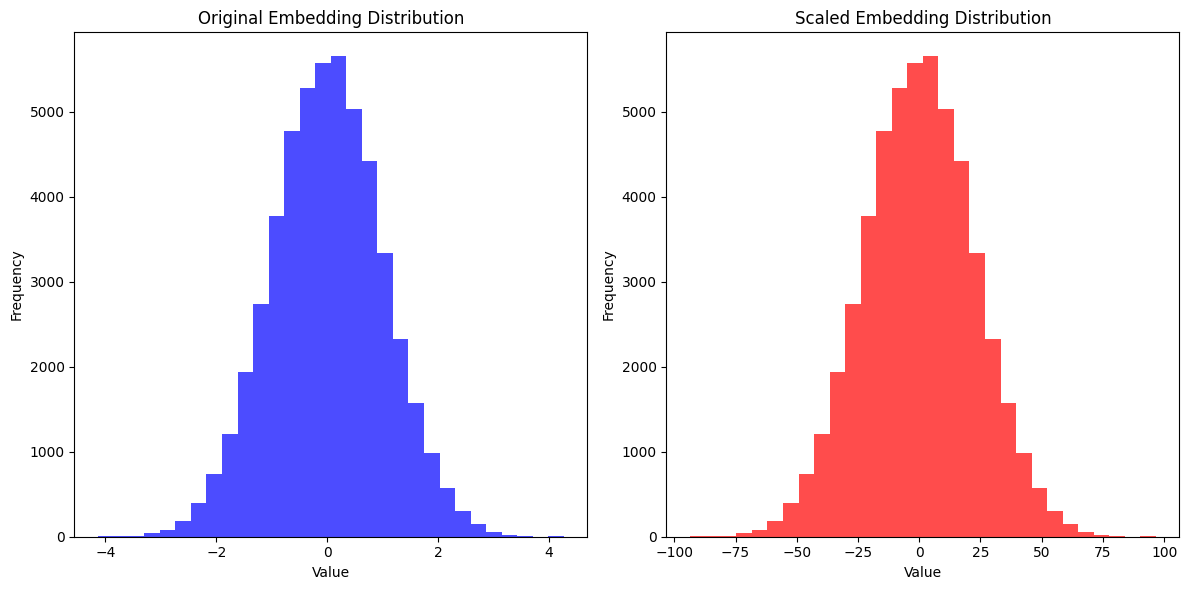

In [27]:
import torch
import matplotlib.pyplot as plt

# 임베딩 벡터와 d_model 설정
d_model = d_model
embedding_vector = torch.randn(100, d_model)

# 스케일링 팩터 적용
scale = torch.sqrt(torch.tensor(d_model, dtype=torch.float32))
scaled_embedding_vector = scale * embedding_vector

# 임베딩 벡터의 분포를 히스토그램으로 시각화
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(embedding_vector.numpy().flatten(), bins=30, color='blue', alpha=0.7)
plt.title("Original Embedding Distribution")
plt.xlabel("Value")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(scaled_embedding_vector.numpy().flatten(), bins=30, color='red', alpha=0.7)
plt.title("Scaled Embedding Distribution")
plt.xlabel("Value")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


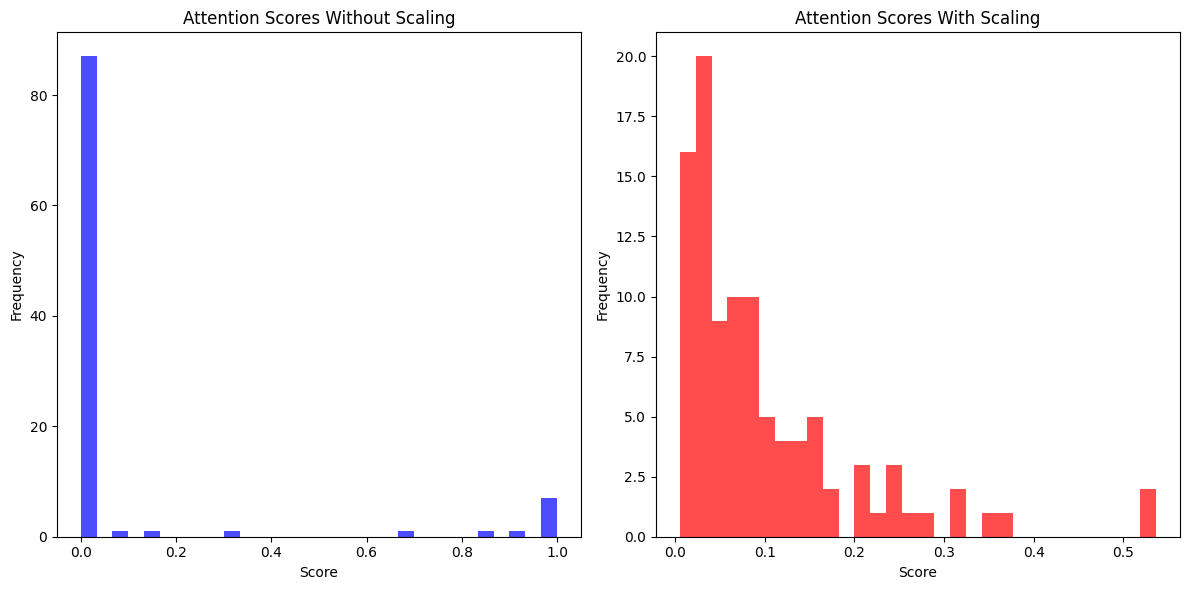

In [28]:
def attention(query, key, scale=None):
    """
    간단한 어텐션 메커니즘을 구현한 함수입니다.
    :param query: 쿼리 벡터
    :param key: 키 벡터
    :param scale: 스케일링 팩터
    :return: 어텐션 스코어
    """
    d_k = query.size(-1)
    
    # query와 key의 내적 계산
    scores = torch.matmul(query, key.transpose(-2, -1))

    if scale:
        scores = scores / scale

    return torch.softmax(scores, dim=-1)

# 임의의 쿼리, 키, 밸류 생성
query = torch.randn(10, d_model)
key = torch.randn(10, d_model)

# 스케일링 적용 전후의 어텐션 스코어 계산
attention_scores_without_scaling = attention(query, key)
attention_scores_with_scaling = attention(query, key, scale)

# 어텐션 스코어의 분포를 히스토그램으로 시각화
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(attention_scores_without_scaling.numpy().flatten(), bins=30, color='blue', alpha=0.7)
plt.title("Attention Scores Without Scaling")
plt.xlabel("Score")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(attention_scores_with_scaling.numpy().flatten(), bins=30, color='red', alpha=0.7)
plt.title("Attention Scores With Scaling")
plt.xlabel("Score")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


## 4)Decoder Components

In [29]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, drop_p):
        """
        DecoderLayer 클래스의 초기화 메소드입니다.
        :param d_model: 모델의 차원 크기
        :param n_heads: 멀티헤드 어텐션의 헤드 수
        :param d_ff: 피드 포워드 네트워크의 내부 차원
        :param drop_p: 드롭아웃 비율
        """
        super().__init__()        
        self.atten = MHA(d_model, n_heads) # Attention for Self & Cross
        self.FF = FeedForward(d_model, d_ff, drop_p) # ff network
        self.LN = nn.LayerNorm(d_model) # Layer Normalization
        self.dropout = nn.Dropout(drop_p) # Dropout

    def forward(self, x, enc_out, dec_mask, enc_dec_mask):
        """
        DecoderLayer 클래스의 순전파 메소드입니다.
        :param x: 디코더의 입력
        :param enc_out: 인코더의 출력
        :param dec_mask: 디코더 마스크
        :param enc_dec_mask: 인코더-디코더 마스크
        """
        x, atten_dec = self.process_sublayer(x, self.atten, self.LN, dec_mask)
        x, atten_enc_dec = self.process_sublayer(x, self.atten, self.LN, enc_dec_mask, enc_out)
        x, _ = self.process_sublayer(x, self.FF, self.LN)

        return x, atten_dec, atten_enc_dec

    def process_sublayer(self, x, sublayer, norm_layer, mask=None, enc_out=None):
        """
        디코더의 서브레이어 처리를 위한 함수.
        :param x: 입력 텐서
        :param sublayer: 서브레이어 (어텐션 또는 피드 포워드)
        :param norm_layer: 레이어 정규화
        :param mask: 마스크 (디코더 또는 인코더-디코더 마스크)
        :param enc_out: 인코더의 출력 (인코더-디코더 어텐션에만 필요)
        """
        x_norm = norm_layer(x)
        if isinstance(sublayer, MHA): # mha case
            if enc_out is not None: # encoder-decoder attention
                residual, atten = sublayer(x_norm, enc_out, enc_out, mask)
            else: # self attention
                residual, atten = sublayer(x_norm, x_norm, x_norm, mask)
        elif isinstance(sublayer, FeedForward): # ff network
            residual = sublayer(x_norm)
            atten = None  # 피드 포워드 레이어는 어텐션 맵을 반환하지 않음
        else:
            raise TypeError("Unsupported sublayer type")

        return x + self.dropout(residual), atten

In [30]:
class Decoder(nn.Module):
    def __init__(self, input_embedding, max_len, d_model, n_heads, n_layers, d_ff, drop_p, vocab_size):
        """
        Decoder 클래스의 초기화 메소드.
        :param input_embedding: 입력 임베딩 레이어
        :param max_len: 입력 시퀀스의 최대 길이
        :param d_model: 모델의 차원 크기
        :param n_heads: 멀티헤드 어텐션의 헤드 수
        :param n_layers: 디코더 레이어의 수
        :param d_ff: 피드 포워드 네트워크의 내부 차원
        :param drop_p: 드롭아웃 비율
        :param vocab_size: 사전의 크기
        """
        super().__init__()        
        self.scale = torch.sqrt(torch.tensor(d_model, dtype=torch.float32))
        self.input_embedding = input_embedding
        self.pos_embedding = nn.Embedding(max_len, d_model)
        self.dropout = nn.Dropout(drop_p)

        self.layers = nn.ModuleList([DecoderLayer(d_model, n_heads, d_ff, drop_p) for _ in range(n_layers)])
        self.LN = nn.LayerNorm(d_model)
        self.fc_out = nn.Linear(d_model, vocab_size)

    def forward(self, trg, enc_out, dec_mask, enc_dec_mask, atten_map_save=False):
        """
        Decoder 클래스의 순전파 메소드.
        :param trg: 타깃 입력
        :param enc_out: 인코더의 출력
        :param dec_mask: 디코더 마스크
        :param enc_dec_mask: 인코더-디코더 마스크
        :param atten_map_save: 어텐션 맵 저장 여부
        """
        pos = torch.arange(trg.shape[1], device=trg.device).repeat(trg.shape[0], 1)

        x = self.scale * self.input_embedding(trg) + self.pos_embedding(pos)
        x = self.dropout(x)

        atten_decs = []
        atten_enc_decs = []
        for layer in self.layers:
            x, atten_dec, atten_enc_dec = layer(x, enc_out, dec_mask, enc_dec_mask)
            if atten_map_save:
                atten_decs.append(atten_dec[0].unsqueeze(0))
                atten_enc_decs.append(atten_enc_dec[0].unsqueeze(0))

        if atten_map_save:
            atten_decs = torch.cat(atten_decs, dim=0)
            atten_enc_decs = torch.cat(atten_enc_decs, dim=0)

        x = self.LN(x) ## decoder layers 이후 LN
        x = self.fc_out(x)
        
        return x, atten_decs, atten_enc_decs

## 5)Transformer

In [31]:
class Transformer(nn.Module):
    def __init__(self, vocab_size, max_len, d_model, n_heads, n_layers, d_ff, drop_p, pad_idx):
        """
        Transformer 클래스의 초기화 메소드.
        :param vocab_size: 어휘 사전의 크기
        :param max_len: 입력 시퀀스의 최대 길이
        :param d_model: 모델의 차원 크기
        :param n_heads: 멀티헤드 어텐션의 헤드 수
        :param n_layers: 인코더 및 디코더 레이어의 수
        :param d_ff: 피드 포워드 네트워크의 내부 차원
        :param drop_p: 드롭아웃 비율
        :param pad_idx: padding token의 index
        """
        super().__init__()
        self.pad_idx = pad_idx
        input_embedding = nn.Embedding(vocab_size, d_model) 
        self.encoder = Encoder(input_embedding, max_len, d_model, n_heads, n_layers, d_ff, drop_p)
        self.decoder = Decoder(input_embedding, max_len, d_model, n_heads, n_layers, d_ff, drop_p, vocab_size)

        self.n_heads = n_heads

        # 파라미터 초기화
        for m in self.modules():
            if hasattr(m, 'weight') and m.weight.dim() > 1: 
                nn.init.xavier_uniform_(m.weight) 

    def make_enc_mask(self, src):
        """
        인코더 마스크 생성.
        :param src: 입력 소스 (batch_size, src_len)
        :return: 인코더 마스크 (batch_size, 1, 1, src_len)
                 - pad_idx에 해당하는 위치는 True, 그 외는 False
        """
        enc_mask = (src == self.pad_idx).unsqueeze(1).unsqueeze(2)
        return enc_mask.repeat(1, self.n_heads, src.shape[1], 1).to(src.device)

    def make_dec_mask(self, trg):
        """
        디코더 마스크 생성 (패딩 마스크 및 미래 토큰 마스킹).
        :param trg: 타깃 입력 (batch_size, trg_len)
        :return: 디코더 마스크 (batch_size, 1, trg_len, trg_len)
                 - 패딩 위치 및 미래 위치는 True, 그 외는 False
        """
        trg_pad_mask = (trg == self.pad_idx).unsqueeze(1).unsqueeze(2)
        trg_pad_mask = trg_pad_mask.repeat(1, self.n_heads, trg.shape[1], 1).to(trg.device)
        trg_dec_mask = torch.tril(torch.ones(trg.shape[0], self.n_heads, trg.shape[1], trg.shape[1], device=trg.device))==0
        dec_mask = trg_pad_mask | trg_dec_mask
        return dec_mask

    def make_enc_dec_mask(self, src, trg):
        """
        인코더-디코더 마스크 생성.
        :param src: 입력 소스 (batch_size, src_len)
        :param trg: 타깃 입력 (batch_size, trg_len)
        :return: 인코더-디코더 마스크 (batch_size, 1, trg_len, src_len)
                 - 소스의 pad_idx 위치는 True, 그 외는 False
        """
        enc_dec_mask = (src == self.pad_idx).unsqueeze(1).unsqueeze(2)
        return enc_dec_mask.repeat(1, self.n_heads, trg.shape[1], 1).to(src.device)

    def forward(self, src, trg):
        enc_mask = self.make_enc_mask(src)
        dec_mask = self.make_dec_mask(trg)
        enc_dec_mask = self.make_enc_dec_mask(src, trg)

        enc_out, atten_encs = self.encoder(src, enc_mask)
        out, atten_decs, atten_enc_decs = self.decoder(trg, enc_out, dec_mask, enc_dec_mask)

        return out, atten_encs, atten_decs, atten_enc_decs

# 6.Training

## 1)Hyper Parameters

In [32]:
save_model_path = './translator_ls.pt'
save_history_path = './translator_history_ls.pt'

In [33]:
DEVICE = 'cuda:0' ## 8대의 GPU 없음

In [34]:
# 논문에 나오는 base 모델
d_model = d_model # 512
n_heads = 8
n_layers = 6
d_ff = 2048
drop_p = 0.1

# # 좀 사이즈 줄인 모델 
# # base model params와 맞춤 : 65 mil
# d_model = 400
# n_heads = 8
# n_layers = 4
# d_ff = 1200
# drop_p = 0.1

In [35]:
# test_DS 테스트
i = 5
idx = test_DS.indices[i]
print(idx) # 엑셀 파일에서 idx번째 문장에 들어있음을 확인할 수 있다
src_text, trg_text = custom_DS.__getitem__(idx)
print(src_text)
print(trg_text)

3537
다른 것은 문제없지만, 협력업체들이 좀 힘들 것 같습니다.
I don't see a problem with anything else, but it's going to be a bit difficult for our partners.


## 2)Train Code

In [36]:
def Train(model, train_DL, val_DL, criterion, optimizer):
    history = {"train": [], "val": [], "lr":[]}
    best_loss = float('inf')

    for ep in range(EPOCH):
        start_time = time.time()  # 에포크 시작 시간 기록

        # 학습 모드
        model.train()
        train_loss = loss_epoch(model, train_DL, criterion, optimizer=optimizer, max_len=max_len, DEVICE=DEVICE, tokenizer=tokenizer)
        history["train"].append(train_loss)

        # 현재 학습률 기록
        current_lr = optimizer.param_groups[0]['lr']
        history["lr"].append(current_lr)
        
        # 평가 모드
        model.eval()
        with torch.no_grad():
            val_loss = loss_epoch(model, val_DL, criterion, max_len=max_len, DEVICE=DEVICE, tokenizer=tokenizer)
            history["val"].append(val_loss)
            epoch_time = time.time() - start_time

            # 로그 출력
            if val_loss < best_loss:
                best_loss = val_loss
                torch.save({"model": model, "ep": ep, "optimizer": optimizer.state_dict(), 'loss':val_loss}, save_model_path)
                print(f"| Epoch {ep+1}/{EPOCH} | train loss:{train_loss:.5f} val loss:{val_loss:.5f} current_LR:{optimizer.param_groups[0]['lr']:.8f} time:{epoch_time:.2f}s => Model Saved!")
            else :
                print(f"| Epoch {ep+1}/{EPOCH} | train loss:{train_loss:.5f} val loss:{val_loss:.5f} current_LR:{optimizer.param_groups[0]['lr']:.8f} time:{epoch_time:.2f}s")

    torch.save({"loss_history": history, "EPOCH": EPOCH, "BATCH_SIZE": BATCH_SIZE}, save_history_path)
    
    show_history(history=history)
    
def show_history(history, save_path='train_history_ls'):
    # train loss, val loss 시각화
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=list(range(1, EPOCH + 1)), y=history["train"], mode='lines+markers', name='Train Loss'))
    fig.add_trace(go.Scatter(x=list(range(1, EPOCH + 1)), y=history["val"], mode='lines+markers', name='Validation Loss'))

    fig.update_layout(
        title='Training History',
        xaxis_title='Epoch',
        yaxis=dict(title='Loss'),
        showlegend=True
    )
    fig.write_image(save_path+".png")
    fig.show()
    
    # learning rate 시각화
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=list(range(1, EPOCH + 1)), y=history['lr'], mode='lines+markers', name='Learning Rate'))

    # 레이아웃 업데이트
    fig.update_layout(
        title='Training History',
        xaxis_title='Epoch',
        yaxis=dict(title='Learning Rate'),
        showlegend=True
    )
    fig.write_image(save_path+"_lr.png")
    fig.show()
    

def loss_epoch(model, DL, criterion, optimizer=None, max_len=None, DEVICE=None, tokenizer=None):
    N = len(DL.dataset) # 데이터 수

    rloss = 0
    for src_texts, trg_texts in tqdm(DL, leave=False):
        src = tokenizer(src_texts, padding=True, truncation=True, max_length=max_len, return_tensors='pt').input_ids.to(DEVICE)
        trg_texts = ['</s> ' + s for s in trg_texts]
        trg = tokenizer(trg_texts, padding=True, truncation=True, max_length=max_len, return_tensors='pt').input_ids.to(DEVICE)
        
        # inference
        y_hat = model(src, trg[:, :-1])[0] # 모델 통과 시킬 때 trg의 <eos>는 제외!
        loss = criterion(y_hat.permute(0, 2, 1), trg[:, 1:]) # 손실 계산 시 <sos> 는 제외!
        if optimizer is not None:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
        
        # loss accumulation
        loss_b = loss.item() * src.shape[0]
        rloss += loss_b
    loss_e = rloss / N
    return loss_e

In [37]:
model = Transformer(vocab_size, max_len, d_model, n_heads, n_layers, d_ff, drop_p, pad_idx).to(DEVICE)

# # 모델의 레이어와 파라미터 출력
# for name, module in model.named_modules():
#     print(name, module)

In [38]:
# 총 파라미터 수 계산
total_params = sum(p.numel() for p in model.parameters())

print(f"Total parameters: {total_params:,}")

Total parameters: 104,968,681


In [39]:
params = model.parameters()

# 논문에서 제시한 beta와 eps 사용 & 맨 처음 step 의 LR=0으로 출발 (warm-up)
optimizer = optim.Adam(params, 
                       lr=0, 
                       betas=(0.9, 0.98), 
                       eps=1e-9) 
scheduler = NoamScheduler(optimizer, d_model=d_model, warmup_steps=warmup_steps, LR_scale=LR_scale)


# 학습은 02.translator_train.py 를 이용
Train(model, train_DL, val_DL, criterion, optimizer)

| Epoch 1/30 | train loss:4.92936 val loss:3.69647 current_LR:0.00123463 time:230.70s => Model Saved!


| Epoch 2/30 | train loss:3.53944 val loss:3.32773 current_LR:0.00114645 time:230.02s => Model Saved!


| Epoch 3/30 | train loss:3.22619 val loss:3.11390 current_LR:0.00093607 time:230.47s => Model Saved!


| Epoch 4/30 | train loss:3.04071 val loss:2.99024 current_LR:0.00081066 time:229.42s => Model Saved!


| Epoch 5/30 | train loss:2.91479 val loss:2.90809 current_LR:0.00072508 time:230.40s => Model Saved!


| Epoch 6/30 | train loss:2.82142 val loss:2.86013 current_LR:0.00066190 time:229.86s => Model Saved!


| Epoch 7/30 | train loss:2.74667 val loss:2.81797 current_LR:0.00061280 time:228.78s => Model Saved!


| Epoch 8/30 | train loss:2.68401 val loss:2.78645 current_LR:0.00057323 time:229.19s => Model Saved!


| Epoch 9/30 | train loss:2.63028 val loss:2.76615 current_LR:0.00054044 time:230.32s => Model Saved!


| Epoch 10/30 | train loss:2.58299 val loss:2.75384 current_LR:0.00051271 time:229.56s => Model Saved!


| Epoch 11/30 | train loss:2.54106 val loss:2.74028 current_LR:0.00048885 time:230.16s => Model Saved!


| Epoch 12/30 | train loss:2.50249 val loss:2.74042 current_LR:0.00046804 time:230.32s


| Epoch 13/30 | train loss:2.46752 val loss:2.73634 current_LR:0.00044968 time:229.10s => Model Saved!


| Epoch 14/30 | train loss:2.43555 val loss:2.73153 current_LR:0.00043332 time:229.97s => Model Saved!


| Epoch 15/30 | train loss:2.40529 val loss:2.73540 current_LR:0.00041862 time:229.57s


| Epoch 16/30 | train loss:2.37816 val loss:2.73200 current_LR:0.00040533 time:230.02s


| Epoch 17/30 | train loss:2.35163 val loss:2.73983 current_LR:0.00039323 time:229.49s


| Epoch 18/30 | train loss:2.32724 val loss:2.74043 current_LR:0.00038215 time:230.51s


| Epoch 19/30 | train loss:2.30388 val loss:2.75379 current_LR:0.00037196 time:229.29s


| Epoch 20/30 | train loss:2.28204 val loss:2.75885 current_LR:0.00036254 time:229.66s


| Epoch 21/30 | train loss:2.26166 val loss:2.76052 current_LR:0.00035380 time:228.00s


| Epoch 22/30 | train loss:2.24224 val loss:2.77194 current_LR:0.00034567 time:229.18s


| Epoch 23/30 | train loss:2.22438 val loss:2.77447 current_LR:0.00033807 time:230.64s


| Epoch 24/30 | train loss:2.20628 val loss:2.78525 current_LR:0.00033095 time:229.61s


| Epoch 25/30 | train loss:2.18927 val loss:2.79102 current_LR:0.00032427 time:230.60s


| Epoch 26/30 | train loss:2.17416 val loss:2.80169 current_LR:0.00031797 time:231.24s


| Epoch 27/30 | train loss:2.15859 val loss:2.80880 current_LR:0.00031202 time:230.48s


| Epoch 28/30 | train loss:2.14412 val loss:2.81623 current_LR:0.00030640 time:229.87s


| Epoch 29/30 | train loss:2.13063 val loss:2.82106 current_LR:0.00030107 time:230.24s


| Epoch 30/30 | train loss:2.11733 val loss:2.83614 current_LR:0.00029601 time:230.90s


TypeError: show_history() got an unexpected keyword argument 'loss_history'

# 7.Validation

## 1)Load Model

In [ ]:
loaded = torch.load('./results/translator_lsce0.2.pt', map_location=DEVICE)
load_model = loaded['model']
ep = loaded['ep']
optimizer = loaded['optimizer']

print(loaded.keys())
print(f"해당 모델은 {loaded['ep']+1} epoch에서 저장된 모델입니다.")

## 2)Test

In [ ]:
def translation(model, src_text, atten_map_save=False, extra_token_length=50):
    model.eval()
    with torch.no_grad():
        src = tokenizer.encode(src_text, return_tensors='pt').to(DEVICE) 
        enc_mask = model.make_enc_mask(src)
        enc_out, atten_enc = model.encoder(src, enc_mask, atten_map_save)

        # 입력 시퀀스의 길이 계산 및 출력 시퀀스의 최대 길이 설정
        max_output_length = src.shape[1] + extra_token_length

        pred = tokenizer.encode('</s>', return_tensors='pt', add_special_tokens=False).to(DEVICE)
        for _ in range(max_output_length):
            dec_mask = model.make_dec_mask(pred)
            enc_dec_mask = model.make_enc_dec_mask(src, pred)
            out, atten_dec, atten_enc_dec = model.decoder(pred, enc_out, dec_mask, enc_dec_mask, atten_map_save)
            
            pred_word = out.argmax(dim=2)[:,-1].unsqueeze(0) 
            pred = torch.cat([pred, pred_word], dim=1) 
            if tokenizer.decode(pred_word.item()) == '</s>':
                break

        translated_text = tokenizer.decode(pred[0])

    return translated_text, atten_enc, atten_dec, atten_enc_dec

In [ ]:
src_text = "개발자가 되려면 어떻게 해야하나요?"
print(f"입력: {src_text}")

translated_text, _, _, _ = translation(load_model, src_text)
print(f"AI의 번역: {translated_text.replace('</s>','')}")

In [ ]:
# 번역해보기
i = 1
idx = test_DS.indices[i]
src_text, trg_text = custom_DS.__getitem__(idx)
print(f"입력: {src_text}")
print(f"정답: {trg_text}")

translated_text, atten_enc, atten_dec, atten_enc_dec = translation(load_model, src_text, atten_map_save = True)
print(f"AI의 번역: {translated_text.replace('</s>','')}")

## 3)Attention Map

In [ ]:
import seaborn as sns

def show_average_attention(atten, Query, Key, style='Pastel1'):
    plt.rc('font', family='NanumBarunGothic')
    atten = atten.cpu()

    # 모든 레이어/헤드에 대한 평균 계산
    atten_avg = atten.mean(dim=1)  # 헤드 차원에 대해 평균
    atten_avg = atten_avg.mean(dim=0)  # 레이어 차원에 대해 평균

    fig, ax = plt.subplots(figsize=[atten_avg.shape[1]*1.5, atten_avg.shape[0]])
    sns.heatmap(atten_avg, annot=True, fmt=".2f", cmap=style, cbar=False, ax=ax,
                yticklabels=Query, xticklabels=Key)

    ax.set_yticklabels(Query, rotation=45, fontsize=15)
    ax.set_xticklabels(Key, rotation=60, fontsize=15)
    ax.xaxis.tick_top()  # x축 레이블을 위쪽으로 이동
    ax.set_title('Average Attention Map', fontsize=12)

    # 외부 경계선 강조
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(2)
        spine.set_color('black')

    plt.tight_layout()
    plt.show()

In [ ]:
enc_input = tokenizer.tokenize(src_text+' </s>') # <eos> 붙여서 학습 시켰기 때문에 여기도 붙여줘야
dec_tokens = tokenizer.tokenize(translated_text) 
dec_input = dec_tokens[:-1] # 디코더 입력으로 들어가는 문장(sos 는 있고 eos는 없고)
dec_output = dec_tokens[1:] # 디코더 출력으로 나간 문장

show_average_attention(atten_enc[:,:,:-1, :-1], enc_input[:-1], enc_input[:-1], style='pink_r') # 번역기 인코더의 경우
show_average_attention(atten_dec[:,:,1:,1:], dec_input[1:], dec_input[1:], style='pink_r')
show_average_attention(atten_enc_dec[:,:,:-1, :-1], dec_output[:-1], enc_input[:-1], style='pink_r') 

## 4)Validation Score

In [ ]:
from torchtext.data.metrics import bleu_score

def calc_bleu_score(model, DS):
    trgs = []
    preds = []

    for i, (src_text, trg_text) in enumerate(DS):
        
        translated_text, _, _, _ = translation(load_model, src_text)

        trg = tokenizer.tokenize(trg_text)
        translated_tok = tokenizer.tokenize(translated_text)

        trgs += [[trg]]
        preds += [translated_tok] 
        
        if (i + 1) % 100 == 0:
            print(f"[{i + 1}/{len(DS)}]")
            print(f"입력: {src_text}")
            print(f"정답: {trg_text}")
            print(f"AI의 번역: {translated_text[4:-4]}")

    bleu = bleu_score(preds, trgs)
    print()
    print(f'Total BLEU Score = {bleu*100:.2f}')

In [ ]:
calc_bleu_score(load_model, test_DS)

In [ ]:
import torch
from torch.nn.functional import log_softmax

def translation(model, src_text, atten_map_save=False, extra_token_length=50):
    model.eval()

    with torch.no_grad():
        src = tokenizer.encode(src_text, return_tensors='pt').to(DEVICE) 
        enc_mask = model.make_enc_mask(src)
        enc_out, atten_enc = model.encoder(src, enc_mask, atten_map_save)

        max_output_length = src.shape[1] + extra_token_length

        pred = tokenizer.encode('</s>', return_tensors='pt', add_special_tokens=False).to(DEVICE)
        word_log_probs = []  # 각 단어의 로그 확률을 저장하는 리스트

        for _ in range(max_output_length):
            dec_mask = model.make_dec_mask(pred)
            enc_dec_mask = model.make_enc_dec_mask(src, pred)
            out, atten_dec, atten_enc_dec = model.decoder(pred, enc_out, dec_mask, enc_dec_mask, atten_map_save)

            log_prob = log_softmax(out, dim=-1)
            pred_word = log_prob.argmax(dim=2)[:,-1].unsqueeze(0)
            
            # 현재 단어의 로그 확률을 리스트에 추가
            word_log_prob = log_prob[0, -1, pred_word].item()
            word_log_probs.append(word_log_prob)

            pred = torch.cat([pred, pred_word], dim=1)
            if tokenizer.decode(pred_word.item()) == '</s>':
                break

        translated_text = tokenizer.decode(pred[0])

    return translated_text, word_log_probs, atten_enc, atten_dec, atten_enc_dec


In [ ]:
from torchtext.data.metrics import bleu_score
import math
import pandas as pd
from tqdm import tqdm

def calc_bleu_ppl_scores(models, DS):
    scores = {'BLEU': {}, 'PPL': {}}

    for model_name, model in models.items():
        trgs = []
        preds = []
        log_probs = []

        for i, (src_text, trg_text) in tqdm(enumerate(DS), total=len(DS), desc=f"Processing {model_name}"):
            # `translation` 함수가 예측한 문장과 각 단어의 로그 확률 리스트를 반환
            translated_text, word_log_probs, _, _, _ = translation(model, src_text)
            trg = tokenizer.tokenize(trg_text)
            translated_tok = tokenizer.tokenize(translated_text)

            trgs += [[trg]]
            preds += [translated_tok]
            log_probs.extend(word_log_probs)  # 로그 확률 리스트를 누적

        bleu = bleu_score(preds, trgs)
        avg_log_prob = sum(log_probs) / len(log_probs)  # 평균 로그 확률
        ppl = math.exp(-avg_log_prob)  # PPL 계산

        scores['BLEU'][model_name] = bleu * 100
        scores['PPL'][model_name] = ppl

    score_matrix = pd.DataFrame(scores)
    return score_matrix


In [ ]:
# 모델 로드
model1 = torch.load('./results/translator_ce.pt', map_location=DEVICE)['model']
model2 = torch.load('./results/translator_lsce0.1.pt', map_location=DEVICE)['model']
model3 = torch.load('./results/translator_lsce0.2.pt', map_location=DEVICE)['model']

In [ ]:
# 모델들을 딕셔너리로 정의
models = {'ce only': model1, 'ce+ls(0.1)': model2, 'ce+ls(0.2)': model3}

In [ ]:
# 함수 호출
score_matrix = calc_bleu_ppl_scores(models, test_DS)

# 결과 출력
display(score_matrix)

In [ ]:
# 함수 호출
score_matrix = calc_bleu_ppl_scores(models, val_DS)

# 결과 출력
display(score_matrix)